In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
df = pd.read_csv('sample_data/california_housing_train.csv')

df


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0
16996,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0
16997,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0
16998,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0


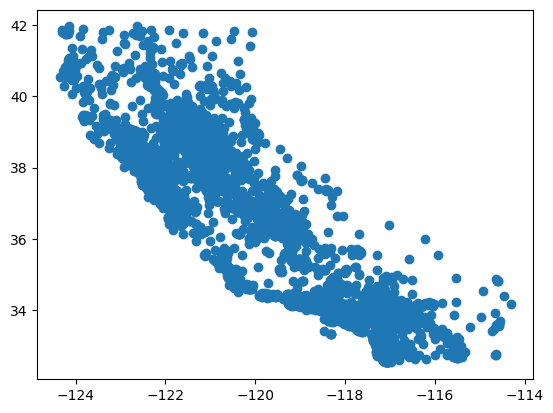

In [3]:
lat_long = df[['latitude', 'longitude']]
lat, longg = df.latitude, df.longitude

plt.scatter(longg, lat)

#epsilon distance to the centroid, points that are necessary for a group to be a core point

In [13]:
X=lat_long.to_numpy()
dbscan_cluster_model=DBSCAN(0.2, min_samples=15).fit(X)
dbscan_cluster_model

DBSCAN(eps=0.2, min_samples=15)

In [15]:
dbscan_cluster_model.labels_   #labeling each point to a cluster

array([-1, -1, -1, ..., -1, -1,  9])

In [16]:
df["cluster"]=dbscan_cluster_model.labels_
df["cluster"]

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
16995    9
16996    9
16997   -1
16998   -1
16999    9
Name: cluster, Length: 17000, dtype: int64

In [18]:
df["cluster"].value_counts()   # summary 16982 to cluster number 1, 10 points to -1 cluster  8 pints to "0" cluster

 2    9065
 4    6999
-1     401
 7     219
 9      95
 0      84
 6      77
 3      21
 5      18
 1      15
 8       6
Name: cluster, dtype: int64

In [17]:
import plotly.express as px
fig=px.scatter(x=longg,y=lat, color=df["cluster"])
fig.show()

In [19]:
#score to -1 very bad to 1 good as
from sklearn.metrics import silhouette_score as ss
ss(X, df["cluster"])

0.25721908993836395

using grid search to optimize the result epsilon and the number of points, is trying every combination

In [20]:
epsilons = np.linspace(0.01, 1, num=15)
epsilons

array([0.01      , 0.08071429, 0.15142857, 0.22214286, 0.29285714,
       0.36357143, 0.43428571, 0.505     , 0.57571429, 0.64642857,
       0.71714286, 0.78785714, 0.85857143, 0.92928571, 1.        ])

In [22]:
min_samples =np.arange(2,20,step=3)
min_samples

array([ 2,  5,  8, 11, 14, 17])

In [23]:
import itertools
combinations = list(itertools.product(epsilons, min_samples))

In [24]:
N=len(combinations)
N

90

# Grid search

we are gonna apply search grid so we have the best combination of epsilon and the number of points

In [25]:
def get_scores_and_labels(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue

    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1],
          'best_labels': best_labels,
          'best_score': best_score}

best_dict = get_scores_and_labels(combinations, X)

Combination (0.01, 2) on iteration 1 of 90 has 2170 clusters. Moving on
Combination (0.01, 5) on iteration 2 of 90 has 945 clusters. Moving on
Combination (0.01, 8) on iteration 3 of 90 has 394 clusters. Moving on
Combination (0.01, 11) on iteration 4 of 90 has 179 clusters. Moving on
Combination (0.01, 14) on iteration 5 of 90 has 75 clusters. Moving on
Index: 5, Score: -0.7351371201118361, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 36
Combination (0.08071428571428571, 2) on iteration 7 of 90 has 130 clusters. Moving on
Combination (0.08071428571428571, 5) on iteration 8 of 90 has 70 clusters. Moving on
Combination (0.08071428571428571, 8) on iteration 9 of 90 has 54 clusters. Moving on
Index: 9, Score: 0.2241184716489065, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 50
Index: 10, Score: 0.23025110810727797, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 45
Index: 11, Score: 0.25576779449421544, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 40
Combination (0.15142857142857144, 2) o

In [26]:
best_dict
df["cluster"]=best_dict["best_labels"]

# FINAL RESULT

In [28]:
fig = px.scatter(x=longg, y=lat, color=df['cluster'])
fig.show()
ss(X, df["cluster"])

In [29]:
print( ss(X, df["cluster"]))

0.4066290757338104
